In [1]:
import os
import pandas as pd

In [2]:
classes = ["Fake", "Real"]
df = pd.read_csv('Preprocessing/news_data_final3.csv')
df['label'] = df['label'].apply(classes.index)
sentences = df['text'].values
label = df['label'].values

In [3]:
from sklearn.model_selection import train_test_split

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, label, test_size=0.25,
                                                                   random_state=42)

### Helper Function to plot Accuracy & Loss

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
def plot_history(history):
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = list(range(1, len(train_acc)+1))
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x, train_acc, label='Training Accuracy')
    plt.plot(x, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(x, train_loss, label='Training Loss')
    plt.plot(x, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()


## Using Keras

In [5]:
from keras import Sequential
from keras.layers import Dense, Embedding, Flatten, GlobalMaxPool1D, LSTM, Conv1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.callbacks import EarlyStopping
import keras

/home/nitin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Using Word Embedding

In [6]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [7]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 500
embedding_dim = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

embedding_matrix = create_embedding_matrix('/scratch/nitin/glove.6B.300d.txt',
                                            tokenizer.word_index, embedding_dim)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          5707200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 5,801,697
Trainable params: 5,801,697
Non-trainable params: 0
_________________________________________________________________
Train on 480 samples, validate on 160 samples
Epoch 1/20
480/480 [==============================] - 11s 22ms/step - loss: 0.6887 - acc: 0.6708 - val_loss: 0.6809 - val_acc: 0.6500
Epoch 2/20
480/480 [==============================] - 10s 20ms/step - loss: 0.6622 -

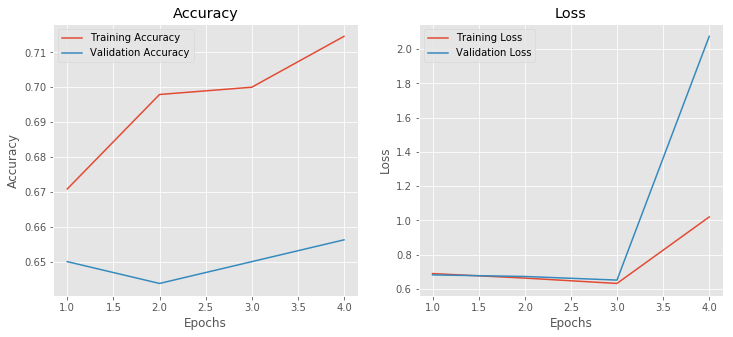

Training Accuracy 0.7583333333333333
Testing Accuracy 0.65625


In [8]:
input_shape = X_train.shape[1]

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen, 
                    weights=[embedding_matrix],
                    trainable=True))

model.add(LSTM(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping()
callbacks_list = [early_stopping]
model.summary()

history = model.fit(X_train, y_train, batch_size=32, epochs=20,
                    validation_data=(X_test, y_test), callbacks = callbacks_list)

plot_history(history=history)
plt.show()
loss, accuracy = model.evaluate(X_train, y_train, verbose = False)
print("Training Accuracy", accuracy)

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy", accuracy)